## Лабораторная работа №1 (курс "Математические методы анализа текстов")

#### Тема: Определение частей речи и выделение именованных сущностей.


**Выдана**:   25 февраля 2017

**Дедлайн**:   <font color='red'>9:00 утра 13 марта 2017</font>

**Среда выполнения**: Jupyter Notebook (Python 2.7)

#### Правила:

Результат выполнения задания - отчет в формате Jupyter Notebook с кодом и выводами. В ходе выполнения задания требуется реализовать все необходимые алгоритмы, провести эксперименты и ответить на поставленные вопросы. Дополнительные выводы приветствуются. Чем меньше кода и больше комментариев - тем лучше.

Все ячейки должны быть "выполненными", при этом результат должен воспроизвдиться при проверке (на Python 2.7). Если какой-то код не был запущен или отрабатывает с ошибками, то пункт не засчитывается. Задание, сданное после дедлайна, _не принимается_. Совсем.


Задание выполняется самостоятельно. Вы можете обсуждать идеи, объяснять друг другу материал, но не можете обмениваться частями своего кода. Если какие-то студенты будут уличены в списывании, все они автоматически получат за эту работу 0 баллов, а также предвзято негативное отношение семинаристов в будущем. Если вы нашли в Интернете какой-то код, который собираетесь заимствовать, обязательно укажите это в задании: вполне вероятно, что вы не единственный, кто найдёт и использует эту информацию.

#### Постановка задачи:

В данной лабораторной работе вам предстоит:

- обучить скрытую марковскую модель на размеченных данных и реализовать алгоритм Витерби для задачи POS-теггинга (определение частей речи слов в тексте)

- научиться использовать ряд POS-теггеров из библиотеки NLTK и сравнить качество их работы

- придумать различные признаки для CRF и использовать их в реализации CRF из пакета CRFsuite для решения задачи NER (выделение именованных сущностей в тексте)

- использовать готовое решение для решения задачи NER и сравнить качество

#### Комментарии и советы:

1. Для выполнения потребуются модули Python numpy, nltk, pycrfsuite (для импорта последнего нужно установить пакет python-crfsuite).

2. Все необходимые для выполнения задания данные либо приложены, либо могут быть скачаны с помощью nltk.download().

3. Посмотреть параметры конструктора и других методов классов можно набрав и выполнив в ячейке с кодом '?full_method_name'.

4. В коде Stanford NER tagger, возможно, присутствует ошибка. Для её устранения в файле /usr/local/lib/python2.7/site-packages/nltk/tag/api.py (или его аналоге в Windows) замените строку с номером 66 на следующую: tagged_sents = self.tag_sents([untag(sent) for sent in gold])

### 1. Определение частей речи (POS)

Мы будем решать задачу определения частей речи (POS-теггинга) с помощью скрытой марковской модели (HMM). Формула совместной плотности наблюдаемых и скрытых переменных задается как

$$ p(X, T) = p(T) p(X|T) = p(t_1)  \prod_{i=2}^N p(t_i|t_{i-1}) \prod_{i=1}^N p(x_i|t_i)$$

В данном случае:

- наблюдаемые переменные $X$ - это слова корпуса;

- скрытые переменные $T$ - это POS-теги.

#### 1.1. Обучение HMM на размеченных данных

Требуется построить скрытую марковскую модель и настроить все ее параметры с помощью оценок максимального правдоподобия по размеченным данным (последовательности пар слово+тег):

- Вероятности переходов между скрытыми состояниями $p(t_i | t_{i - 1})$ посчитайте на основе частот биграмм POS-тегов.

- Вероятности эмиссий наблюдаемых состояний $p(x_i | t_i)$ посчитайте на основе частот "POS-тег - слово".

- Обратите внимание на проблему разреженности счетчиков и сделаейте все вероятности сглаженными по Лапласу (add-one smoothing).

- Распределение вероятностей начальных состояний $p(t_1)$ задайте равномерным.

Обратите внимание, что так как мы используем размеченные данные, то у нас нет необходимости в оценивании апостериорных вероятностей на скрытые переменные с помощью алгоритма forward-backword и использовании EM-алгоритма.

In [1]:
import numpy as np
from sklearn.base import BaseEstimator
        

class HMM(BaseEstimator) :
    
    def __init__(self, sequence, labels) :
        
        print('Построение модели...')
        
        self.labels_dict = dict(zip(labels, range(len(labels))))
        word_unic = set([word[0] for word in sequence])
        ends_unic = set([word[0][-2:] for word in sequence])
        self.word_dict = dict(zip(word_unic, range(len(word_unic))))
        self.ends_dict = dict(zip(ends_unic, range(len(word_unic))))
        self.labels = labels
        self.label_dist = np.zeros(len(labels))
        
        self.start_dist = 1 / len(labels) * np.ones(len(labels))
        self.ll_matrix = np.ones((len(labels),len(labels)))
        self.wl_matrix = np.ones((len(word_unic), len(labels)))
        self.ends_matrix = np.ones((len(ends_unic), len(labels)))
        self.unknown_list = []
        
        print('Модель построена')
    
    def fit(self, sequence) :
        
        print('Обучение модели...')
        
        self.wl_matrix[self.word_dict.get(sequence[0][0])][self.labels_dict.get(sequence[0][1])] += 1
        self.label_dist[self.labels_dict.get(sequence[0][1])] += 1
        self.ends_matrix[self.ends_dict.get(sequence[0][0][-2:])][self.labels_dict.get(sequence[0][1])] += 1
        for i in range(1 , len(sequence)) :
            
            self.ll_matrix[self.labels_dict.get(sequence[i-1][1])][self.labels_dict.get(sequence[i][1])] += 1
            self.wl_matrix[self.word_dict.get(sequence[i][0])][self.labels_dict.get(sequence[i][1])] += 1
            self.ends_matrix[self.ends_dict.get(sequence[i][0][-2:])][self.labels_dict.get(sequence[i][1])] += 1
            self.label_dist[self.labels_dict.get(sequence[i][1])] += 1
        
        self.label_dist /= len(sequence)
        
        ll_sum = self.ll_matrix.sum(axis = 1)
        wl_sum = self.wl_matrix.sum(axis = 0)
        ends_sum = self.ends_matrix.sum(axis = 0)
            
        self.ll_matrix = np.array([self.ll_matrix[i, :] / ll_sum[i] for i in range(self.ll_matrix.shape[0])])
        self.wl_matrix = np.array([self.wl_matrix[:, i] / wl_sum[i] for i in range(self.wl_matrix.shape[1])]).T
        self.ends_matrix = np.array([self.ends_matrix[:, i] / ends_sum[i] for i in range(self.wl_matrix.shape[1])]).T
        
        print('Модель обучена')
    
    def viterbi_algorithm(self, test_token_list) :
        
        print('Выполняется...')
        
        delta = np.zeros((len(self.labels), len(test_token_list)))
        s = np.zeros((len(self.labels), len(test_token_list) - 1))
        unknown_count = 0
        answer = []
        
        
        delta[:, 0] = np.array([np.log(self.start_dist[i]) + \
                                np.log(self.wl_matrix[self.word_dict.get(test_token_list[0])][i]) for i in range(len(self.labels))])
        for i in range(1, len(test_token_list)) :
            d_delta = delta[:, i-1]
            if test_token_list[i] in self.word_dict :
                word_idx = self.word_dict.get(test_token_list[i])
                delta[:, i] = np.array([max(d_delta + np.log(self.ll_matrix[:, k])) + \
                                            np.log(self.wl_matrix[word_idx][k]) for k in range(len(labels))])
                s[:, i - 1] = np.array([np.argmax(d_delta + np.log(self.ll_matrix[:, k])) for k in range(len(labels))])
            elif test_token_list[i][-2:] in self.ends_dict :
                ends_idx = self.ends_dict.get(test_token_list[i][-2:])
                delta[:, i] = np.array([max(d_delta + np.log(self.ll_matrix[:, k])) + \
                                            np.log(self.ends_matrix[ends_idx][k]) for k in range(len(labels))])
                s[:, i - 1] = np.array([np.argmax(d_delta + np.log(self.ll_matrix[:, k])) for k in range(len(labels))])
            else :
                self.unknown_list.append(i)
                unknown_count += 1
        
        last_state = np.argmax(delta[:, len(test_token_list) - 1])
        answer.append(last_state)
        for i in range(s.shape[1] - 1, -1 , -1) :
            last_state = int(s[last_state, i])
            answer.append(last_state)
        
        tmp_list = self.labels
        for i in self.labels_dict :
            tmp_list[self.labels_dict.get(i)] = i
            
        predict = []
        for i in range(len(answer)) :
            predict.append(tmp_list[answer[i]])
        predict = predict[::-1]
        print('Готово')
        
        return predict
    
    def get_ll_matrix(self) :
        return self.ll_matrix
    
    def get_wl_matrix(self) :
        return self.wl_matrix
    
    def get_label_dist(self) :
        return self.label_dist
    
    def get_word_dict(self) :
        return self.word_dict
    
    def get_ends_matrix(self) :
        return self.ends_matrix
    def get_unknown_list(self) :
        return self.unknown_list
    def get_labels_dict(self):
        return self.labels_dict

Загрузите brown корпус с универсальной системой тегирования. Для этого вам понадобятся ресурсы brown и universal_tagset из nltk.download().  В этой системе содержатся следующие теги:

- ADJ - adjective (new, good, high, ...)
- ADP - adposition	(on, of, at, ...)
- ADV - adverb	(really, already, still, ...)
- CONJ	- conjunction	(and, or, but, ...)
- DET - determiner, article	(the, a, some, ...)
- NOUN	- noun	(year, home, costs, ...)
- NUM - numeral	(twenty-four, fourth, 1991, ...)
- PRT -	particle (at, on, out, ...)
- PRON - pronoun (he, their, her, ...)
- VERB - verb (is, say, told, ...)
- .	- punctuation marks	(. , ;)
- X	- other	(ersatz, esprit, dunno, ...)

Обратите внимание, что тегсеты в корпусах текстов и в различных теггерах могут быть разными. Проверять это можно, глядя на сами теги, а симптом - подозрительно низкое качество теггирования. В таких случаях рекомендуется всё приводить сперва к универсальному тегсету, а потом уже мерять качество. Полезной может оказаться эта ссылка http://www.nltk.org/_modules/nltk/tag/mapping.html

Проанализируйте данные, с которыми Вы работаете. В частности, ответьте на вопросы:
- Каков общий объем датасета, формат?
- Приведены ли слова к нижнему регистру? Чем  это нам может в дальнейшем помешать?
- Как распределены слова в корпусе?  Как распределены теги в корпусе? Подсчитайте частоты и отобразите любым удобным для Вас способом. Проинтерпретируйте полученные результаты.

Задем сделайте случайное разбиение выборки на обучение и контроль в отношении 9:1 и обучите скрытую марковскую модель из предыдущего пункта. Если впоследствии обучение моделей будет занимать слишком много времени, работайте с подвыборкой, например, только текстами определенных категорий.

In [2]:
import random

def train_test_split(text, ratio = 0.9) :
    
    random.shuffle(text)
    end_train = int(0.9 * len(text))
    return text[: end_train], text[end_train : ]

In [3]:
from nltk import corpus
brown_tagged_set = corpus.brown.tagged_sents(tagset="universal")
train, test = train_test_split(list(brown_tagged_set))

In [4]:
listmerge = lambda t : [el for lst in t for el in lst]
train, test = listmerge(train), listmerge(test)

In [5]:
print("Объем датасета = ", len(train) + len(test), "слов")

Объем датасета =  1161192 слов


In [6]:
train = [(t[0].lower(), t[1]) for t in train]
test = [(t[0].lower(), t[1]) for t in test]

Слова в корпусе не были приведены к нижнему регистру, что может сильно увеличить размер словаря и снизить качество разметки.

In [7]:
labels = ['ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRT', 'PRON', 'VERB', '.', 'X']

In [8]:
hmm = HMM(train, labels)

Построение модели...
Модель построена


In [9]:
import time
t = time.time()
hmm.fit(train)
print("Время обучения ", time.time() - t, " секунд")

Обучение модели...
Модель обучена
Время обучения  5.350347995758057  секунд


In [13]:
import seaborn
import matplotlib.pyplot as plt
d_w = {}
d_l = {}
for w in train :
    if w[0] in d_w :
        d_w[str(w[0])] = d_w[str(w[0])] + 1
    else :
        d_w[str(w[0])] = 1
    if w[1] in d_l :
        d_l[str(w[1])] = d_l[str(w[1])] + 1
    else :
        d_l[str(w[1])] = 1
w_sorted = sorted(d_w.items(), key=lambda t: t[1], reverse=True)
w_sorted = w_sorted[:20]

# Частоты по словам

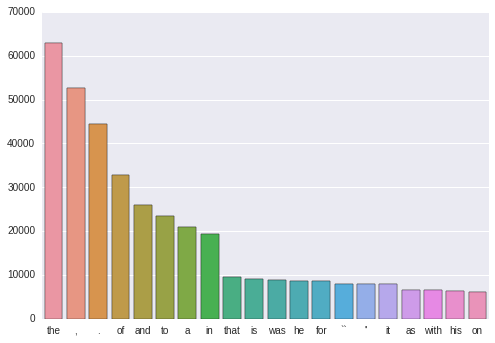

In [14]:
seaborn.barplot([i[0] for i in w_sorted[:20]], [i[1] for i in w_sorted[:20]])
plt.show()

График частот слов согласуется с законом Ципфа.

# Частоты по частям речи

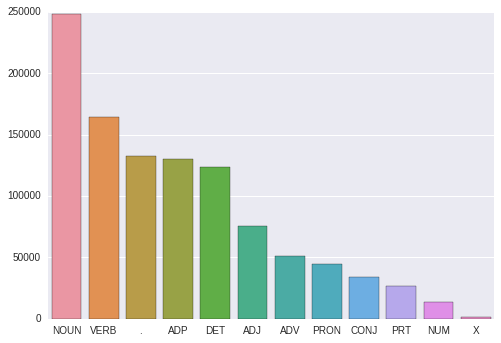

In [17]:
l_sorted = sorted(d_l.items(), key=lambda t: t[1], reverse=True)
seaborn.barplot([i[0]for i in l_sorted], [i[1] for i in l_sorted])
plt.show()

Как и ожидалось наиболее часто встречающимися оказались существительные.

In [18]:
test_list = [t[0].lower() for t in test]
test_tags = [t[1] for t in test]

In [19]:
t = time.time()
predict = hmm.viterbi_algorithm(test_list)
print("Время предсказания ", time.time() - t, " секунд")

Выполняется...
Готово
Время предсказания  30.09011220932007  секунд


#### 1.2 Алгоритм Витерби для применения модели

Чтобы использовать обученную модель для определения частей речи на новых данных, необходимо реализовать алгоритм Витерби. Это алгоритм динамиеского программирования, с помощью которого мы будем находить наиболее вероятную последовательность скрытых состояний модели для фиксированной последовательности слов:

$$ \hat{T} = \arg \max_{T} p(T|X) = \arg \max_{T} p(X, T) $$

Определим функцию, определяющую максимальную вероятность последовательности, заканчивающейся на $i$-ой позиции в состоянии $k$:

$$\delta(k, i) = \max_{t_1, \dots t_{i-1}} p(x_1, \dots x_i, t_1, \dots t_i=k)$$

Тогда $\max_{k} \delta(k, N)$ - максимальная вероятность всей последовательности. А состояния, на которых эта вероятность достигается - ответ задачи.

Алгоритм Витерби заключается в последовательном пересчете функции $\delta(k, i)$ по формуле:

$$\delta(k, i) = \max_{m} \delta(m, i-1) p(t_i = k|t_{i-1} = m) p(x_i|t_i=k) $$

Аналогично пересчитывается функция, определяющая, на каком состоянии этот максимум достигается:

$$s(k, i) = \arg \max_{m} \delta(m, i-1) p(t_i = k|t_{i-1} = m) p(x_i|t_i=k) $$


На практике это означает заполнение двумерных массивов размерности: (длина последовательности) $\times$ (количество возможных состояний). Когда массивы заполнены, $\arg \max_{k} \delta(k, N)$ говорит о последнем состоянии. Начиная с него можно восстановить все состояния по массиву $s$. 

Осталось уточнить, как стартовать последовательный пересчет (чем заполнить первый столбец массива вероятностей):

$$\delta(k, 1) = p(k) p(x_1|t_1=k)$$

В реализации рекомендуется перейти к логарифмам, т.к. произведение большого числа маленьких вероятностей может приводить к вычислительным ошибкам.

Проверьте работу реализованного алгоритма на следующих модельных примерах, проинтерпретируйте результат.

- 'he can stay'
- 'a milk can'
- 'i saw a dog'
- 'an old saw'

In [20]:
predict1 = hmm.viterbi_algorithm(['he', 'can', 'stay'])
predict2 = hmm.viterbi_algorithm(['a', 'milk', 'can'])
predict3 = hmm.viterbi_algorithm(['i', 'saw', 'a', 'dog'])
predict4 = hmm.viterbi_algorithm(['an', 'old', 'saw'])

Выполняется...
Готово
Выполняется...
Готово
Выполняется...
Готово
Выполняется...
Готово


In [21]:
print(predict1)
print(predict2)
print(predict3)
print(predict4)

['PRON', 'VERB', 'VERB']
['DET', 'NOUN', 'VERB']
['PRON', 'VERB', 'DET', 'NOUN']
['DET', 'ADJ', 'VERB']


Неправильно определилась часть слова 'saw' в 4 примере. Возможно не хватило статистики на обучении, но выглядит странно.

Примените модель к отложенной выборке Брауновского корпуса и подсчитайте точность определения тегов (accuracy). Сделайте выводы. 

In [22]:
from sklearn.metrics import accuracy_score
print("HMM model accuracy = ", accuracy_score(test_tags, predict))

HMM model accuracy =  0.944401564492


На отложенной выборке алгоритм показывает хорошее качество, думаю тут помогла обработка незнакомых слов (а не просто объявление их "unknown"). 

#### 1.3. Готовые POS-теггеры из NLTK

В прошлом пункте Вы реализовали свой POS-тегер на основе скрытой марковской модели. Теперь сравните его работу с готовыми средставми, доступными в библиотеке NLTK: http://www.nltk.org/api/nltk.tag.html

Примерный набор кандидатов для сравнения:
- Простейший теггер, который всем словам ставит в соответствие одну и ту же метку
- Основанный на правилах RegexpTagger (правила можно поискать в Интернете или придумать самим)
- N-граммные теггеры (разберитесь и поэкспериментируйте с параметром backoff)
- Теггеры на основе графических моделей (можно взять только Stanford): 
    - HiddenMarkovModelTagger
    - CRFTagger
    - StanfordPOSTagger (потребуется .jar файл теггера и обученная модель (легко находятся в Интернете), чтобы подать на вход конструктору класса)
- BrillTagger, основанный на трансформациях

Если работа с какими-то модулями приводит к техническим проблемам, которые Вы не можете решить, это не страшно, модуль можно пропустить. Однако навык быстрого освоения документации / поиска моделей в гугле полезен.  Чем более полным и корректным будет сравнение, тем лучше.

При проведении экспериментов обращайте внимание на следующие моменты (и отразите их в отчете):
- Какой подход лежит в основе теггера
- На каких данных он обучен (если Вы скачали готовую модель)
- Сколько времени занимает обучение на brown корпусе (если обучаете сами)
- Какая точность получается на контролькой выборке (метод evaluate())

Сформируйте рекоммендиции о том, какую технологию Вы бы использовали, если встретитесь с задачей определения частей речи в будущем.

In [23]:
import nltk
from nltk.tag import DefaultTagger
from nltk.tag import RegexpTagger
from nltk.tag import UnigramTagger
from nltk.tag import BigramTagger
from nltk.tag import TrigramTagger
from nltk.tag import  HiddenMarkovModelTagger
from nltk.tag import CRFTagger
from nltk.tag.stanford import StanfordPOSTagger
from nltk.tag import BrillTagger

In [24]:
default_tagger = DefaultTagger('NOUN')
t = time.time()
default_predict = list(default_tagger.tag(test_list))
print("DefaultTagger время обучения", time.time() - t)
print("DefaultTagger accuracy = ",accuracy_score(test_tags, [dp[1] for dp in default_predict]))

DefaultTagger время обучения 0.13225936889648438
DefaultTagger accuracy =  0.23733620099


Default Tagger просто проставляет всем словам в выборке одну метку. Это самый простой тэггер.

In [25]:
import re
regexp_tagger = RegexpTagger(
    [(r'^-?[0-9]+(.[0-9]+)?$', 'NUM'),   
    (r'\W+?$', '.'),
    (r'(The|the|A|a|An|an|some|Some)$', 'DET'),   
    (r'(one|two|tree|four|five|six|seven|eight|nine|ten|eleven|twelve)$', 'NUM'),
    (r'(on|in|at|near|over|under|between|among|behind|across|through|to|towards|from|into|during|before|after|between)$', 'ADP'),
    (r'(also|and|as|because|but|however|if|once|or|still|so|than|that|)$', 'CONJ'),
    (r'(therefore|although|thus|what|while|yet|for|with|without)$', 'CONJ'),
    (r'(i|you|he|she|it|we|they|me|him|her|it|us|them|other|another)$', 'PRON'),
    (r'.*one$', 'NUM'),
    (r'.*two$', 'NUM'),
    (r'.*three$', 'NUM'),
    (r'.*four$', 'NUM'),
    (r'.*five$', 'NUM'),
    (r'.*six$', 'NUM'),
    (r'.*seven$', 'NUM'),
    (r'.*eight$', 'NUM'),
    (r'.*nine$', 'NUM'),
    (r'.*th$', 'NUM'),
    (r'.*able$', 'ADJ'),
    (r'.*ful$', 'ADJ'),
    (r'.*less$', 'ADJ'),
    (r'.*ible$', 'ADJ'),
    (r'.*ic$', 'ADJ'),
    (r'.*ical$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
    (r'.*ate$', 'ADJ'),
    (r'.*ish$', 'ADJ'),
    (r'.*ive$', 'ADJ'),
    (r'.*ness$', 'NOUN'),                
    (r'.*ly$', 'ADV'),
    (r'.*ically$', 'ADV'),
    (r'.*s$', 'NOUN'),                 
    (r'.*ing$', 'VERB'),               
    (r'.*ed$', 'VERB'),
    (r'.*en$', 'VERB'),
    (r'.*ize$', 'VERB'),
    (r'.*fy$', 'VERB'),
    (r'.*', 'NOUN')                     
 ])
t = time.time()
regexp_predict = list(regexp_tagger.tag(test_list))
print("RegexpTagger время обучения", time.time() - t)
print("RegexpTagger accuracy = ",accuracy_score(test_tags, [rp[1] for rp in regexp_predict]))

RegexpTagger время обучения 5.140694618225098
RegexpTagger accuracy =  0.644450996887


RegexpTagger уже более проодвинутый тэггер. Его работа построена на перечне правил, с помощью которых он размечает слова. Работает довольно быстро, но качество плохое. Думаю, что если напридумывать еще кучу правил, можно добиться отностильно неплохого качества.

In [26]:
brown_tagged_sents = corpus.brown.tagged_sents(categories='news', tagset = 'universal')
size = int(len(brown_tagged_sents) * 0.9)
train_sents = brown_tagged_sents[:size]
test_sents = brown_tagged_sents[size:]
t = time.time()
unigram_tagger = UnigramTagger(train_sents)
print("UnigrammTagger время обучения", time.time() - t)
print("UnigrammTagger accuracy = ",unigram_tagger.evaluate(test_sents))

UnigrammTagger время обучения 0.6842460632324219
UnigrammTagger accuracy =  0.8455098176019137


Униграммный тэггер ставит в соответствие слову ниболее вероятный тэг, который определяется по обучающему корпусу. 
Обучение n-gramm тэггеров проводилось на brown корпусе, катеория "news". 

In [27]:
t = time.time()
bigram_tagger = BigramTagger(train_sents, backoff = unigram_tagger)
print("BigrammTagger время обучения", time.time() - t)
print("BigrammTagger accuracy = ",bigram_tagger.evaluate(test_sents))

BigrammTagger время обучения 1.2607378959655762
BigrammTagger accuracy =  0.8497956742748929


Биграммный тэггер в качестве контекста использует не только сам токен, но и тэг предыдущего слова и проставляет наиболее вероятный тэг в соответствии с контекстом текущего слова. Если корпус небольшой, то тэггеру может не хватить статистики на пару (слово, предущий тэг) и качество будет неудовлетворительным. Выходом может быть композиция тэггеров. Я применил композицию биграм-тэггера и униграм-тэггера. Параметр backoff определяет алгоритм, который будет применен для разметки в случае, если не справился текущий. Качество такого тэггера заметно лучше по сравнению с тэгерром без параметра backoff и немного лучше по сравнению с униграммным тэггером. 

In [28]:
t = time.time()
trigram_tagger = TrigramTagger(train_sents, backoff = bigram_tagger)
print("TrigrammTagger время обучения = ",time.time() - t)
print("TrigrammTagger accuracy = ",trigram_tagger.evaluate(test_sents))

TrigrammTagger время обучения =  1.6026456356048584
TrigrammTagger accuracy =  0.8479019236519486


Здесь в контекст добавился еще тэг предпредыдущего слова. Качество практически не изменилось. 

In [16]:
import os
from nltk.tag.stanford import StanfordPOSTagger
os.environ['CLASSPATH'] = os.path.join(
   os.path.curdir, 'stanford-postagger-2015-04-20'
)
os.environ['STANFORD_MODELS'] = os.path.join(
    os.path.curdir, 'stanford-postagger-2015-04-20', 'models'
)
stanford_tagger = StanfordPOSTagger('english-bidirectional-distsim.tagger')

In [30]:
import nltk.tag.mapping
import time
ts = [el[0] for lst in test_sents for el in lst]
t = time.time()
ts_tagging = stanford_tagger.tag(ts)
print("StanfordPOSTagger время = ", time.time() - t)

StanfordPOSTagger время =  9.85373854637146


In [31]:
ts_tagging = [nltk.tag.mapping.map_tag('en-ptb', 'universal', t[1]) for t in ts_tagging]

In [32]:
print("StanfordPOSTagger accuracy = ", accuracy_score(ts_tagging,[el[1] for lst in test_sents for el in lst]))

StanfordPOSTagger accuracy =  0.928934516097


В основе Stanford тэггера модель максималльной энтропиии. Обучен на brown корпусе, катеория "news". Качество высокое, работает быстро.

In [33]:
from nltk.tag import BrillTaggerTrainer

trainer = BrillTaggerTrainer(unigram_tagger, nltk.tag.brill.brill24(), 3, ruleformat="str")

In [34]:
min_acc = None
start = time.time()
brill_tagger = trainer.train(train_sents, 300, 3, min_acc)
finish = time.time()

TBL train (fast) (seqs: 4160; tokens: 90521; tpls: 24; min score: 3; min acc: None)
Finding initial useful rules...
    Found 29930 useful rules.

           B      |
   S   F   r   O  |        Score = Fixed - Broken
   c   i   o   t  |  R     Fixed = num tags changed incorrect -> correct
   o   x   k   h  |  u     Broken = num tags changed correct -> incorrect
   r   e   e   e  |  l     Other = num tags changed incorrect -> incorrect
   e   d   n   r  |  e
------------------+-------------------------------------------------------
 274 391 117   3  | PRT->ADP if Pos:DET@[1]
  61  88  27   1  | PRT->ADP if Pos:NOUN@[1] & Pos:NOUN@[2]
  51  62  11   0  | NOUN->VERB if Pos:PRT@[-1] & Pos:DET@[1]
  35  56  21   1  | PRT->ADP if Pos:NUM@[1]
  38  42   4   0  | ADP->PRT if Word:up@[0]
  35  65  30   1  | PRT->ADP if Pos:NOUN@[-1] & Pos:NOUN@[1]
  36  36   0   0  | ADP->PRT if Word:all@[0]
  34  52  18   0  | PRT->ADP if Pos:ADJ@[1] & Pos:NOUN@[2]
  26  51  25   0  | VERB->NOUN if Pos:DET@[-1

In [35]:
print("BrillTagger время обучения = ", finish - start)
print("BrillTagger accuracy = ", brill_tagger.evaluate(test_sents))

BrillTagger время обучения =  34.00211477279663
BrillTagger accuracy =  0.8583673876208512


Для обучения Brilltagger нужен какой-нибудь тэггер, я взял UnigrammTagger, и свод правил, взял стандартный brill24(). При обучении алгоритм выбирает нужные правила, которые действительно улучшают качество работы базового алгоритма. Тэггер обучен на brown корпусе, категория "news". Показал неплохое качество, но работает довольно долго. Думаю подбором правил и базового тэггера можно добиться хорошего качества.

### 2. Выделение именованных сущностей (NER)



#### 2.1. Генерация признаков для CRF

Выделение именованных сущностей - другая распространенная задача разметки последовательности слов. Чаще всего она решается марковскими моделями максимальной энтропии (MEMM) или условными случайными полями (CRF). При этом основная сложность заключается в генерации  хороших признаков. 

В данном задании Вам требуется придумать и использовать множество признаков для обучения CRF из библиотеки CRFsuite. В этой библиотеке реализована linear-chain CRF с потенциалами двух типов (аналогично HMM):

$$ \psi_{mk}(t_{i-1}, t_{i}) = [t_{i-1} = m] \, [t_{i} = k]; \quad \psi_{jk}(t_{i}, x_i) = [t_{i} = k] \, f_j(x_i)$$


Потенциалы первого типа назвают transition features, они зависят только от биграмм меток. Потенциалы второго типа -- label-observation (node-observation) featrues; они зависят от метки и признаков наблюдаемого слова (observation features). Несмотря на то, что в формуле явно участвует текущее слово $x_i$, подход остается полностью корректным, когда признаки зависят также от контекста слова (соседних слов). Это следствие того, что CRF является дискриминативной моделью, и наблюдаемые переменные $X$ не моделируются. 


**Указания к заданию:** 
- Загрузите из NLTK обучающие и тестовые датасеты для задачи выделения именованных сущеностей CoNLL 2002 shared task на английском, испанском и голландском языках в BIO-нотации (nltk.corpus.conll2002).
- Для обучения CRF модели библиотеке необходимо передать последовательность наблюдаемых признаков $f_j(x_i)$ и меток $y_i$. Ниже приведен весь технический код, который позволит сконцентрироваться только на самом творческом этапе -- генерации признаков.
- Оцените качество приведенного решения. 
- Ваша задача заключается в том, чтобы повысить его. Помимо генерации новых признаков, можно обратить внимание на параметры обучения, в частности, feature.minfreq позволяет отсеивать редкие признаки.  
- При проверке задания будет оцениваться как достигнутое качество, так и разнообразие/оригинальность использованных признаков. Если вы попробовали какие-то признаки, но они не помогли, также включите их в отчет. 
- Если у Вас закончилась фантазия, почитайте обзоры и статьи по теме.


In [36]:
def reduce_mask(word) :
    res = ''
    for i in range(len(word)) :
        if word[i].isdigit() :
            res += 'd'
        elif word[i].isalpha() :
            if word[i].isupper() :
                res += 'X'
            else :
                res += 'x'
        else :
            res += word[i]
        if i > 0 and res[-2:][0] == res[-2:][1] :
            res = res[:len(res)-1]
    return res
def mask(word) :
    res = ''
    for i in range(len(word)) :
        if word[i].isdigit() :
            res += 'd'
        elif word[i].isalpha() :
            if word[i].isupper() :
                res += 'X'
            else :
                res += 'x'
        else :
            res += word[i]
    return res

In [37]:
# Let's define very simple example features.

def word2features(sent, i):

    word = sent[i][0]
    postag = sent[i][1]
    features = [
        'bias',
        'word.lower=' + word.lower(),
        'word[-3:]=' + word[-3:],
        'word[:3]=' + word[:3],
        'word.isupper=%s' % word.isupper(),
        'word.islower=%s' % word.islower(),
        'word.isalnum=%s' % word.isalnum(),
        'word.isalpha=%s' % word.isalpha(),
        'word.isdigit=%s' % word.isdigit(),
        'postag=' + postag,
        'word.istitle=%s' % word.istitle(),
        'word_mask=' + mask(word),
        'word_reduce_mask=' + reduce_mask(word),
        'word_point=%s' % (word.count('.') > 0),
        'word_hyphen=%s' % (word.count('-') > 0)
        
    ]
    if i < len(sent)-1 :
        word2 = sent[i+1][0]
        postag2 = sent[i+1][1]
        features.extend([
            '+1:word.lower=' + word2.lower(),
            'word1[-3:]=' + word2[-3:],
            'word1[:3]=' + word2[:3],
            '+1:word.isupper=%s' % word2.isupper(),
            '+1:word.islower=%s' % word2.islower(),
            '+1:word.isalnum=%s' % word2.isalnum(),
            '+1:word.isalpha=%s' % word2.isalpha(),
            '+1:word.isdigit=%s' % word2.isdigit(),
            '+1:postag=' + postag2,
            '+1:word.istitle=%s' % word2.istitle(),
            '0+1:word=' + word.lower() + word2.lower(),
            'word2_mask=' + mask(word2),
            'word2_reduce_mask=' + reduce_mask(word2),
            '0+1:word_mask=' + mask(word) + mask(word2),
            'word2_point=%s' % (word2.count('.') > 0),
            'word2_hyphen=%s' % (word2.count('-') > 0)
        ])
        if i < len(sent) - 2 :
            word3 = sent[i+2][0]
            postag3 = sent[i+2][1]
            features.extend([
                '+2:word.isupper=%s' % word3.isupper(),
                '+2:postag=' + postag3,
                '+2:word.istitle=%s' % word3.istitle(),
                'word3_mask=' + mask(word3),
                '1+2:word_mask=' + mask(word2) + mask(word3)
            ])
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.extend([
            '-1:word.lower=' + word1.lower(),
            'word2[-3:]=' + word1[-3:],
            'word2[:3]=' + word1[:3],
            '-1:word.isupper=%s' % word1.isupper(),
            '-1:word.islower=%s' % word1.islower(),
            '-1:word.isalnum=%s' % word1.isalnum(),
            '-1:word.isalpha=%s' % word1.isalpha(),
            '-1:word.isdigit=%s' % word1.isdigit(),
            '-1:postag=' + postag1,
            '-1:word.istitle=%s' % word1.istitle(),
            '-1+0:word=' + word1.lower() + word.lower(),
            'word1_mask=' + mask(word1),
            'word1_reduce_mask=' + reduce_mask(word1),
            '-1+0:word_mask=' + mask(word1) + mask(word),
            'word1_point=%s' % (word1.count('.') > 0),
            'word1_hyphen=%s' % (word1.count('-') > 0)
        ])
        if i > 1:
            word4 = sent[i-2][0]
            postag4 = sent[i-2][1]
            features.extend([
                '-2:word.isupper=%s' % word4.isupper(),
                '-2:postag=' + postag4,
                '-2:word.istitle=%s' % word4.istitle(),
                'word4_mask=' + mask(word4),
                '-2-1:word_mask=' + mask(word4) + mask(word1)
            ])
    else:
        features.append('BOS')
    
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

Для генерации признаков текущего слова использовались : само слово и его тэг, 2 предыдущих слова с их тэгами и 2 последющих слова с их тэгами. В качестве признаков использовались суффик и префикс слова, тэг, бинарные признаки типа (слово ничинается с большой буквы, состоит из цифр и букв и тд). Так же в качестве признака использовал маску слова и сокращенную маску слова, количство специальных символов в слове такких как "." и "-". На делеких словах от текущего - через одно вперед и назад, использование всех признаков понижало качество, поэтому выбрал самые информативные.

In [38]:
# Let's prepare functions for more comfortable work with pycrfsuite.

import pycrfsuite

MODEL_NAME = 'model.crfsuite'

def train(train):
    X_train = [sent2features(s) for s in train]
    y_train = [sent2labels(s) for s in train]

    trainer = pycrfsuite.Trainer(verbose=False)

    trainer.set_params({'c1': 1.0, 'c2': 1e-3, 'max_iterations': 50,
                        'feature.possible_transitions': True})

    for xseq, yseq in zip(X_train, y_train):
        trainer.append(xseq, yseq)

    trainer.train(MODEL_NAME)

def evaluate(test):
    X_test = [sent2features(s) for s in test]
    y_test = [sent2labels(s) for s in test]

    tagger = pycrfsuite.Tagger()
    tagger.open(MODEL_NAME)

    y_pred = [tagger.tag(x) for x in X_test]

    true_counter, total_counter = 0.0, 0.0
    for p, t in zip(y_pred, y_test):
        assert len(p) == len(t)
        total_counter += len(p)
        true_counter += sum([str(i) == str(j) for i, j in zip(p, t)])
    return true_counter / total_counter

In [39]:
import nltk
from nltk.corpus import conll2002

In [40]:
train_sents_esp = conll2002.iob_sents('esp.train')
test_sents_esp = conll2002.iob_sents('esp.testa')

In [41]:
t = time.time()
train(train_sents_esp)
print('CRFmodel_esp время = ', time.time() - t)

CRFmodel_esp время =  117.94473791122437


In [42]:
print('CRFmodel_esp accuracy = ', evaluate(test_sents_esp))

CRFmodel_esp accuracy =  0.9582601137501653


In [43]:
train_sents_ned = conll2002.iob_sents('ned.train')
test_sents_ned = conll2002.iob_sents('ned.testa')

In [44]:
t = time.time()
train(train_sents_ned)
print('CRFmodel_ned время = ', time.time() - t)

CRFmodel_ned время =  75.13403749465942


In [45]:
print('CRFmodel_ned accuracy = ', evaluate(test_sents_ned))

CRFmodel_ned accuracy =  0.9707060790192905


In [1]:
from nltk.corpus import conll2000

In [2]:
train_sents_eng = conll2000.iob_sents('train.txt', tagset = 'universal')
test_sents_eng = conll2000.iob_sents('test.txt', tagset = 'universal')

In [48]:
t = time.time()
train(train_sents_eng)
print('CRFmodel_eng время = ', time.time() - t)

CRFmodel_eng время =  128.03015065193176


In [49]:
print('CRFmodel_eng accuracy = ', evaluate(test_sents_eng))

CRFmodel_eng accuracy =  0.9542605061527746


#### 2.2. Stanford NER tagger

Воспользуйтесь StanfordNERTagger для решения задачи NER на тех же тестовых данных, только для английского языка (обучать модель здесь не требуется). Приведите данные в соответствие нужному формату. Сравните результат с полученным выше. Настройка StanfordNERTagger производится аналогично настройке StanfordPOSTagger. В качестве готовой модели можно взять 'english.all.3class.distsim.crf.ser.gz'.

In [17]:
from nltk.tag import StanfordNERTagger

In [19]:
os.environ['CLASSPATH'] = os.path.join(
   os.path.curdir, 'stanford-ner-2014-06-16'
)
os.environ['STANFORD_MODELS'] = os.path.join(
    os.path.curdir, 'stanford-ner-2014-06-16', 'classifiers'
)
stanford_ner_tagger = StanfordNERTagger('english.all.3class.distsim.crf.ser.gz')

In [21]:
test = [el[0] for lst in test_sents_eng for el in lst]
tags = [el[2] for lst in test_sents_eng for el in lst]

In [53]:
stanford_ner_tagger.tag(test)

[('Rockwell', 'ORGANIZATION'),
 ('International', 'ORGANIZATION'),
 ('Corp.', 'ORGANIZATION'),
 ("'s", 'O'),
 ('Tulsa', 'LOCATION'),
 ('unit', 'O'),
 ('said', 'O'),
 ('it', 'O'),
 ('signed', 'O'),
 ('a', 'O'),
 ('tentative', 'O'),
 ('agreement', 'O'),
 ('extending', 'O'),
 ('its', 'O'),
 ('contract', 'O'),
 ('with', 'O'),
 ('Boeing', 'ORGANIZATION'),
 ('Co.', 'ORGANIZATION'),
 ('to', 'O'),
 ('provide', 'O'),
 ('structural', 'O'),
 ('parts', 'O'),
 ('for', 'O'),
 ('Boeing', 'ORGANIZATION'),
 ("'s", 'O'),
 ('747', 'O'),
 ('jetliners', 'O'),
 ('.', 'O'),
 ('Rockwell', 'PERSON'),
 ('said', 'O'),
 ('the', 'O'),
 ('agreement', 'O'),
 ('calls', 'O'),
 ('for', 'O'),
 ('it', 'O'),
 ('to', 'O'),
 ('supply', 'O'),
 ('200', 'O'),
 ('additional', 'O'),
 ('so-called', 'O'),
 ('shipsets', 'O'),
 ('for', 'O'),
 ('the', 'O'),
 ('planes', 'O'),
 ('.', 'O'),
 ('These', 'O'),
 ('include', 'O'),
 (',', 'O'),
 ('among', 'O'),
 ('other', 'O'),
 ('parts', 'O'),
 (',', 'O'),
 ('each', 'O'),
 ('jetliner', 'O'),

Английский датасет с "нормальными" тэгами не нашел, поэтому просто запустил тэгер без проверки качества. Визуально работает хорошо)